In [1]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
#     'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG11': [64, 'M', 96, 'M', 128, 128, 'M', 256, 256, 'M', 256, 'M', 256, 256],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, n_classes, vgg_name='VGG11'):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(256, n_classes)
        self.n_classes = n_classes

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [2]:
from collections import OrderedDict

def extract_submodule(parent_module, module_path):
    """
    Extracts a submodule given a hierarchical path string like 'features.8'.
    Returns the submodule and its immediate parent.
    """
    module_names = module_path.split('.')
    submodule = parent_module
    for name in module_names:
        submodule = getattr(submodule, name)
    return submodule

def add_modules(source, first_part, second_part, split_layer, include_split_layer_in_first_part = True, parent_name=""):
    """
    Adds a range of layers/modules from `source` to `target`.
    """
    passed_split_layer = False
    for name, module in source.named_children():
        if parent_name == "":
            joined_name = name
        else:
            joined_name =  parent_name + "_" + name
        if name == split_layer:
            if include_split_layer_in_first_part:
                first_part.add_module(joined_name, module)
            else:
                second_part.add_module(joined_name, module)
            passed_split_layer = True
            continue
        if not passed_split_layer:
            first_part.add_module(joined_name, module)
        else:
            second_part.add_module(joined_name, module)
            if name == "avgpool":
                # if avgpool is global avgpool
                second_part.add_module("flatten", nn.Flatten())

def get_sub_model(original_model, start_layer_name, end_layer_name, include_split_layer_in_first_part=False):
    _, second_part = split_model(original_model, start_layer_name, include_split_layer_in_first_part)
    start_layer_split = start_layer_name.split('.')
    end_layer_split = end_layer_name.split('.')
    max_index = min(len(start_layer_split), len(end_layer_split))
    new_end_layer_name = ""
    for index in range(max_index):
        if new_end_layer_name != "":
            new_end_layer_name += "_" + end_layer_split[index]
        else:
            new_end_layer_name = end_layer_split[index]
        if start_layer_split[index] != end_layer_split[index]:
            if index < max_index-1:
                new_end_layer_name += "." + ".".join(end_layer_split[index+1:])
            break
    # print(second_part)
    return split_model(second_part, new_end_layer_name, True)[0]

def _split_model(source, remaining_name, root_name_list, first_part, second_part, include_split_layer_in_first_part=True):
    if "." not in remaining_name:
        add_modules(source, first_part, second_part, remaining_name, include_split_layer_in_first_part, "_".join(root_name_list))
    else:
        new_root, new_remaining = remaining_name.split('.', 1)
        passed_new_root = False
        for name, module in source.named_children():
            if len(root_name_list) == 0:
                joined_name = name
            else:
                joined_name =  "_".join(root_name_list) + "_" + name
            if name == new_root:
                root_name_list.append(new_root)
                _split_model(extract_submodule(source, new_root), new_remaining, root_name_list, first_part, second_part, include_split_layer_in_first_part)
                root_name_list.pop()
                passed_new_root = True
                continue
            if not passed_new_root:
                first_part.add_module(joined_name, module)
            else:
                second_part.add_module(joined_name, module)
                if name == "avgpool":
                    # if avgpool is global avgpool
                    second_part.add_module("flatten", nn.Flatten())

def split_model(original_model, split_layer_name, include_split_layer_in_first_part=True):
    """
    Splits a model into two parts at the specified split layer.
    Handles nested modules like `features.8`.
    """
    first_part = nn.Sequential(OrderedDict())
    second_part = nn.Sequential(OrderedDict())
    
    _split_model(original_model, split_layer_name, [], first_part, second_part, include_split_layer_in_first_part)

    return first_part, second_part

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision.transforms as transforms
import torchvision
import random
import math

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # ToChannelLast(),
])

testset = torchvision.datasets.CIFAR10(
    root='kaggle/dataset', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 106564794.19it/s]


Extracting kaggle/dataset/cifar-10-python.tar.gz to kaggle/dataset


In [6]:
path = "/kaggle/input/cifar10_vgg11/pytorch/pretrained/1/cifar-base10.pth"
net = VGG(10, 'VGG11')
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True
saved = torch.load(path, map_location=device)
net.load_state_dict(saved['net'])
print('Accuracy: ', saved['acc'])
net = net.module.to(device)
print(net)

Accuracy:  91.85
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14)

In [7]:
split_layer = 'features.17'
first_part, second_part = split_model(net, split_layer, include_split_layer_in_first_part=True)

print(first_part)
print(second_part)

# start_layer = 'features.8'
# end_layer = 'features.20'
# sub_model = get_sub_model(net, start_layer, end_layer, False)
# print(sub_model)


Sequential(
  (features_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features_2): ReLU(inplace=True)
  (features_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features_6): ReLU(inplace=True)
  (features_7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_8): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features_10): ReLU(inplace=True)
  (features_11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
'''import for slic'''
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms.functional as TF

import skimage.segmentation as seg
from skimage.util import img_as_float
from skimage import io
from PIL import Image

In [9]:
'''utils'''
def load_image(path):
    return io.imread(path)

def show_image(image):
    image = np.array(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
def show_PIL(img):
    img = np.array(img)
    img = (img - img.min()) / (img.max() - img.min())
    img *= 255
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    
def show(img):
    img = np.array(img)
    img -= img.min();img /= img.max()
    img = np.transpose(img, (1,2,0))
    plt.imshow(img); plt.axis('off')
    
def _batch_inference(model, dataset, batch_size=128, device='cpu'):
    nb_batchs = math.ceil(len(dataset) / batch_size)
    start_ids = [i*batch_size for i in range(nb_batchs)]
    results = []

    with torch.no_grad():
        for i in start_ids:
            x = torch.tensor(dataset[i:i+batch_size])
            x = x.to(device)   
            results.append(model(x))

    results = torch.cat(results)
    return results

In [10]:
'''
input: vector 3 chiều ảnh + số segment(n)
output: vector 2 chiều label từ: 1 -> x (x <= n) 
'''
def to_slic1(image, numSegments):
    segments = seg.slic(image, n_segments=numSegments, max_num_iter=50,compactness=100)
    return segments
def tensor_to_pil(tensor):
    """
    Converts a normalized torch tensor to a PIL image.
    
    Args:
        tensor (torch.Tensor): The normalized tensor with shape (C, H, W).
        mean (list or tuple): The mean used for normalization (one value per channel).
        std (list or tuple): The standard deviation used for normalization (one value per channel).

    Returns:
        PIL.Image: The converted PIL image.
    """
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    tensor = tensor.detach().cpu()

    # Undo normalization
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]
    tensor = tensor * std + mean

    # Convert to NumPy array and permute dimensions to (H, W, C)
    np_array = tensor.permute(1, 2, 0).numpy()
    np_array = (np_array * 255).astype(np.uint8)
    image = Image.fromarray(np_array)
    
    return image

def to_slic(tensor, n_segments=100, compactness=10):
    """
    Segments a normalized torch tensor image using SLIC algorithm.
    
    Args:
        tensor (torch.Tensor): The normalized tensor with shape (C, H, W).
        mean (list or tuple): The mean used for normalization (one value per channel).
        std (list or tuple): The standard deviation used for normalization (one value per channel).
        n_segments (int): The (approximate) number of labels in the segmented output image.
        compactness (float): Balances color proximity and space proximity.

    Returns:
        np.ndarray: The segmented image.
    """
    # Convert the tensor to a PIL image
    pil_image = tensor_to_pil(tensor)
    np_image = np.array(pil_image)
    segments = seg.slic(np_image, n_segments=n_segments, compactness=compactness)
    
    return segments

'''
thêm nhiều Gauss vào các phần khác phần label truyền vào
'''
def add_gaussian_noise_to_area(image, segments, label, mean=0, std=25):
    image = np.array(image)
    mask = (segments == label)
    inverted_mask = ~mask
    
    outside_area = image.copy()
    outside_area[inverted_mask] = 0
    
    noise = np.random.normal(mean, std, image.shape)
    noisy_outside_area = outside_area + noise
    noisy_outside_area = np.clip(noisy_outside_area, 0, 255)
    
    noisy_image = image.copy()
    noisy_image[inverted_mask] = noisy_outside_area[inverted_mask]
    
    return noisy_image.astype(np.uint8)

def find_image_index(crop_index, all_images, patch_size, stride):
    # Assuming images are square and all have the same size
    image_height, image_width = all_images.size(2), all_images.size(3)  # Get dimensions of the images
    
    # Calculate the number of patches along one dimension
    num_patches_one_dimension = ((image_width - patch_size) // stride) + 1
    
    # Total number of patches per image
    num_patches_per_image = num_patches_one_dimension ** 2
    
    # Calculate the index of the image from which the crop was taken
    image_index = crop_index // num_patches_per_image
    
    return image_index

def get_crop_bounding_box(crop_index, image_size, all_images, patch_size, stride):
    image_index = find_image_index(crop_index, all_images, patch_size, stride)
    # Calculate the number of patches along one dimension
    num_patches_one_dimension = int((image_size[0] - patch_size) // stride) + 1
    
    # Determine the row and column of the crop in the grid
    index_to_original_image = crop_index - (num_patches_one_dimension**2) * image_index
    row = index_to_original_image // num_patches_one_dimension
    col = index_to_original_image % num_patches_one_dimension
    
    # Calculate the top-left corner of the bounding box
    x = col * stride
    y = row * stride
    
    # Define the bounding box [x, y, width, height]
    bounding_box = [x, y, patch_size, patch_size]
    
    return image_index, bounding_box

from PIL import ImageDraw
from IPython.display import display 

def draw_bounding_box_on_image(image_index, bounding_box, all_images):
    # Convert the PyTorch tensor to a NumPy array and then to a PIL Image
    image_array = all_images[image_index].clone().detach().cpu().numpy()  # Ensure channel last format
    if image_array.dtype != np.uint8:
        image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)

    # Convert the array to a PIL Image
    image = Image.fromarray(image_array.transpose(1, 2, 0))

    # Create a drawing context
    draw = ImageDraw.Draw(image)
    
    # Calculate coordinates for the rectangle
    x, y, width, height = bounding_box
    rectangle = [x, y, x + width, y + height]

    # Draw the rectangle on the image
    draw.rectangle(rectangle, outline="red", width=1)
    
    # Display the image using IPython's display function
    return image

# img = all_images[20].detach().cpu()
# show(img)
# plt.show()
# segments = to_slic(img, 10)
# print(segments.shape)
# masked_img = add_gaussian_noise_to_area(tensor_to_pil(img), segments, 4, mean=0, std=100)
# show_image(masked_img)
# plt.show()


In [11]:
all_images = []
all_labels = []
for img, label in testloader:
    all_images.append(img)
    all_labels.append(label)
    
all_images = torch.cat(all_images).to(device)
all_labels = torch.cat(all_labels).to(device)

label_list = [0,1]


with torch.no_grad():  # Disable gradient computation for inference
    outputs = net(all_images)
    _, predicted_labels = torch.max(outputs, 1)
    
predicted_labels = predicted_labels.detach().cpu()
mask = torch.isin(predicted_labels, torch.tensor(label_list))
all_images = all_images[mask]
all_labels = all_labels[mask]
print(all_images.shape)

misclassified_mask = torch.isin(all_labels, torch.tensor(label_list).to(device))
misclassified_indices = torch.where(misclassified_mask, False, True)
misclassified_indices = [index.item() for index in misclassified_indices]
misclassified_images = all_images[misclassified_indices]
print(misclassified_images.shape)

torch.Size([1991, 3, 32, 32])
torch.Size([136, 3, 32, 32])


In [12]:
patch_size = 16
strides = int(patch_size * 0.5)
crops = torch.nn.functional.unfold(all_images, kernel_size=patch_size, stride=strides)
crops = crops.transpose(1, 2).contiguous().view(-1, 3, patch_size, patch_size)
crops = torch.nn.functional.interpolate(crops, size=32, mode='bilinear', align_corners=False)
print(crops.shape)

split_layer = 'features.31'
first_part, second_part = split_model(net, split_layer, include_split_layer_in_first_part=True)

def get_activation_vecs(model, data, batch_size, device):
    out = _batch_inference(model, data, batch_size, device)
    out = torch.mean(out, dim=(2,3))
    out = out.detach().cpu().numpy()
    return out
out = get_activation_vecs(first_part, crops, 128, device)
print(out.shape)

torch.Size([17919, 3, 32, 32])


/tmp/ipykernel_24/1791079572.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


(17919, 256)


In [13]:
from sklearn.decomposition import NMF, DictionaryLearning, PCA
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
import warnings

def get_surogate_model(n_components, acts, Y, split_size = 0.2, seed = 42, max_depth=10, batch_size=128, max_iter=300):
    assert max_depth >= 2
    reducer = NMF(n_components=n_components, max_iter = 300)
    # reducer = PCA(n_components=n_components)
    # reducer = DictionaryLearning(n_components=n_components)
    reducer.fit(out)
    X = reducer.transform(acts)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_size, random_state=seed)
    max_cluster_acc = -1
    best_depth = -1
    # find the best depth
    for depth in range(2, max_depth+1):
        clf = DecisionTreeClassifier(random_state=seed, max_depth = depth)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        if accuracy > max_cluster_acc:
            max_cluster_acc = accuracy
            best_depth = depth
    # best clf model
    clf = DecisionTreeClassifier(random_state=seed, max_depth = best_depth)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    return accuracy, best_depth, clf

acts = get_activation_vecs(first_part, all_images, 128, device)
Y = all_labels.detach().cpu().numpy().reshape(-1,1)
    
max_components = 20
max_acc = -1
best_n_components = -1
best_clf = -1
best_depth = -1

for n_components in range(1,max_components+1):
    accuracy, best_depth, clf = get_surogate_model(n_components, acts, Y)
    if accuracy > max_acc:
        max_acc = accuracy
        best_n_components = n_components
        best_clf = clf
        best_depth = clf.max_depth
    print(f"Number of components {n_components} with accuracy: {accuracy * 100:.2f}%")

/tmp/ipykernel_24/1791079572.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Number of components 1 with accuracy: 59.15%
Number of components 2 with accuracy: 87.97%
Number of components 3 with accuracy: 90.23%
Number of components 4 with accuracy: 89.72%
Number of components 5 with accuracy: 89.97%
Number of components 6 with accuracy: 89.72%
Number of components 7 with accuracy: 89.72%
Number of components 8 with accuracy: 89.47%
Number of components 9 with accuracy: 88.72%
Number of components 10 with accuracy: 87.22%
Number of components 11 with accuracy: 89.47%
Number of components 12 with accuracy: 89.72%
Number of components 13 with accuracy: 90.23%
Number of components 14 with accuracy: 89.47%
Number of components 15 with accuracy: 89.47%
Number of components 16 with accuracy: 89.22%
Number of components 17 with accuracy: 89.22%
Number of components 18 with accuracy: 89.72%
Number of components 19 with accuracy: 89.97%
Number of components 20 with accuracy: 89.72%


Label: 0


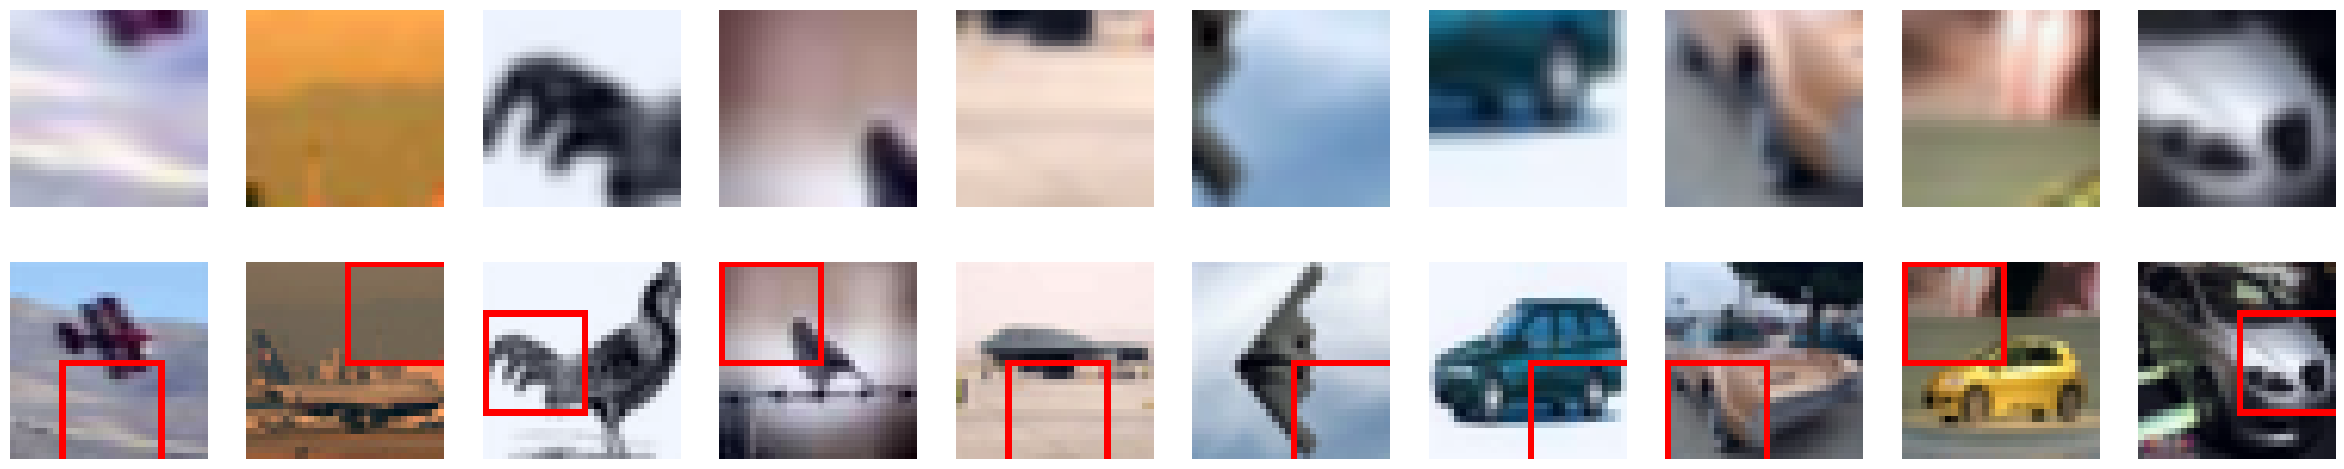




Label: 1


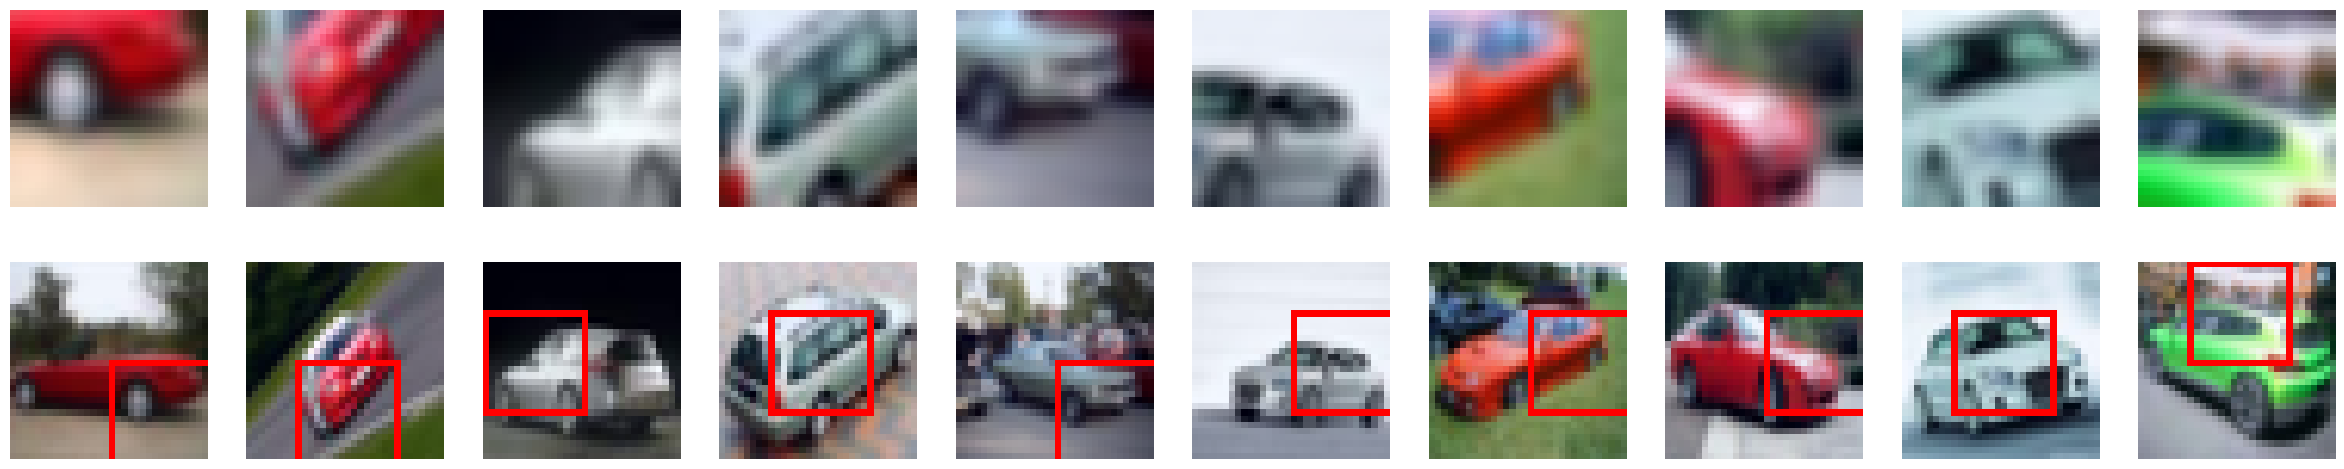




Label: 2


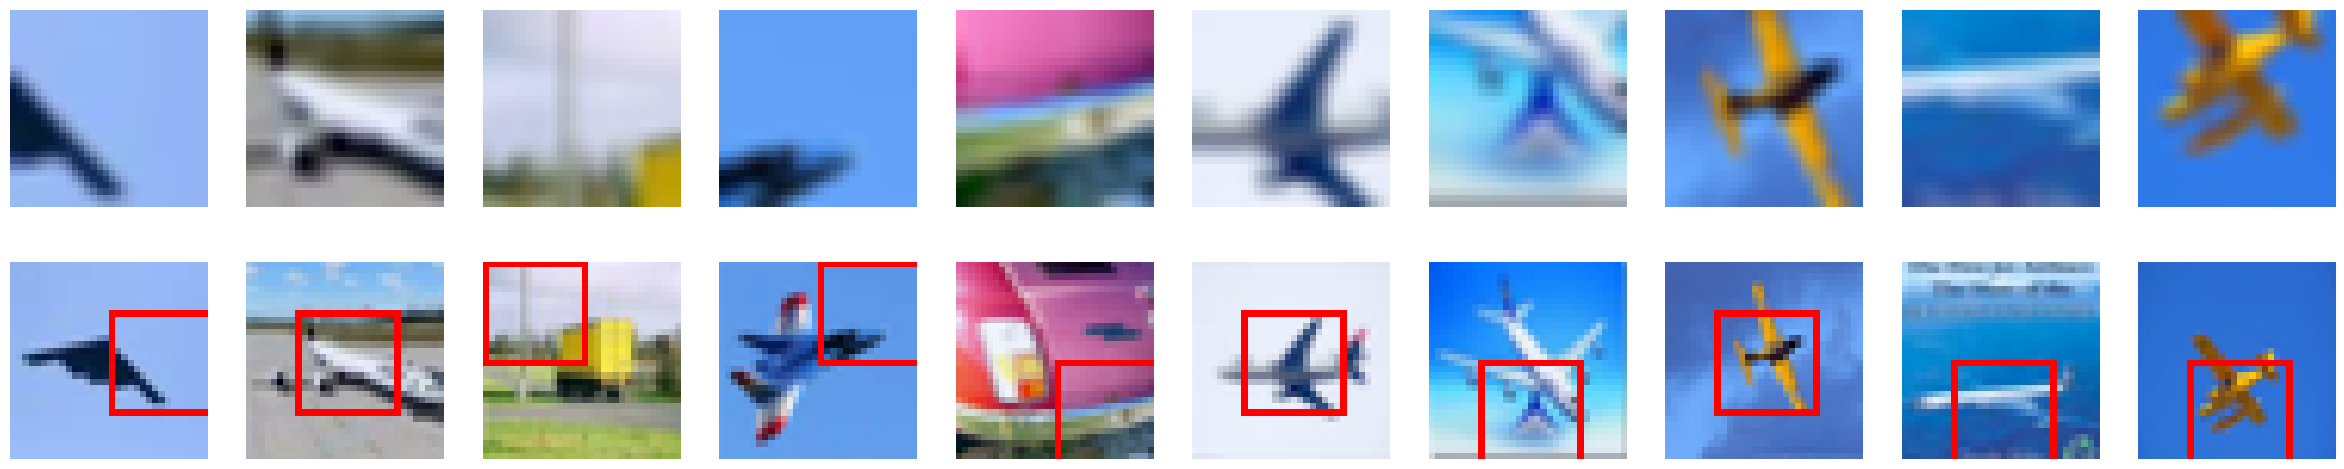

In [14]:
reducer = NMF(n_components=best_n_components)
# reducer = PCA(n_components=n_components)
# reducer = DictionaryLearning(n_components=n_components)
u = reducer.fit_transform(out)
w = reducer 
nb_crops = 10
for c_id in range(best_n_components):
    print("Label:", c_id)
    plt.figure(figsize=(nb_crops*3, 2*3))
    
    best_crops_ids = np.argsort(u[:, c_id])[::-1][:nb_crops]
    for i, index in enumerate(best_crops_ids):
        plt.subplot(2, nb_crops, i+1)
        show(crops[index].detach().cpu())
        original_index, bounding_box = get_crop_bounding_box(index, (32,32), all_images, patch_size, strides)
        plt.subplot(2, nb_crops, i+1+nb_crops)
        show_PIL(draw_bounding_box_on_image(original_index, bounding_box, all_images))
    plt.show()
    print('\n\n')

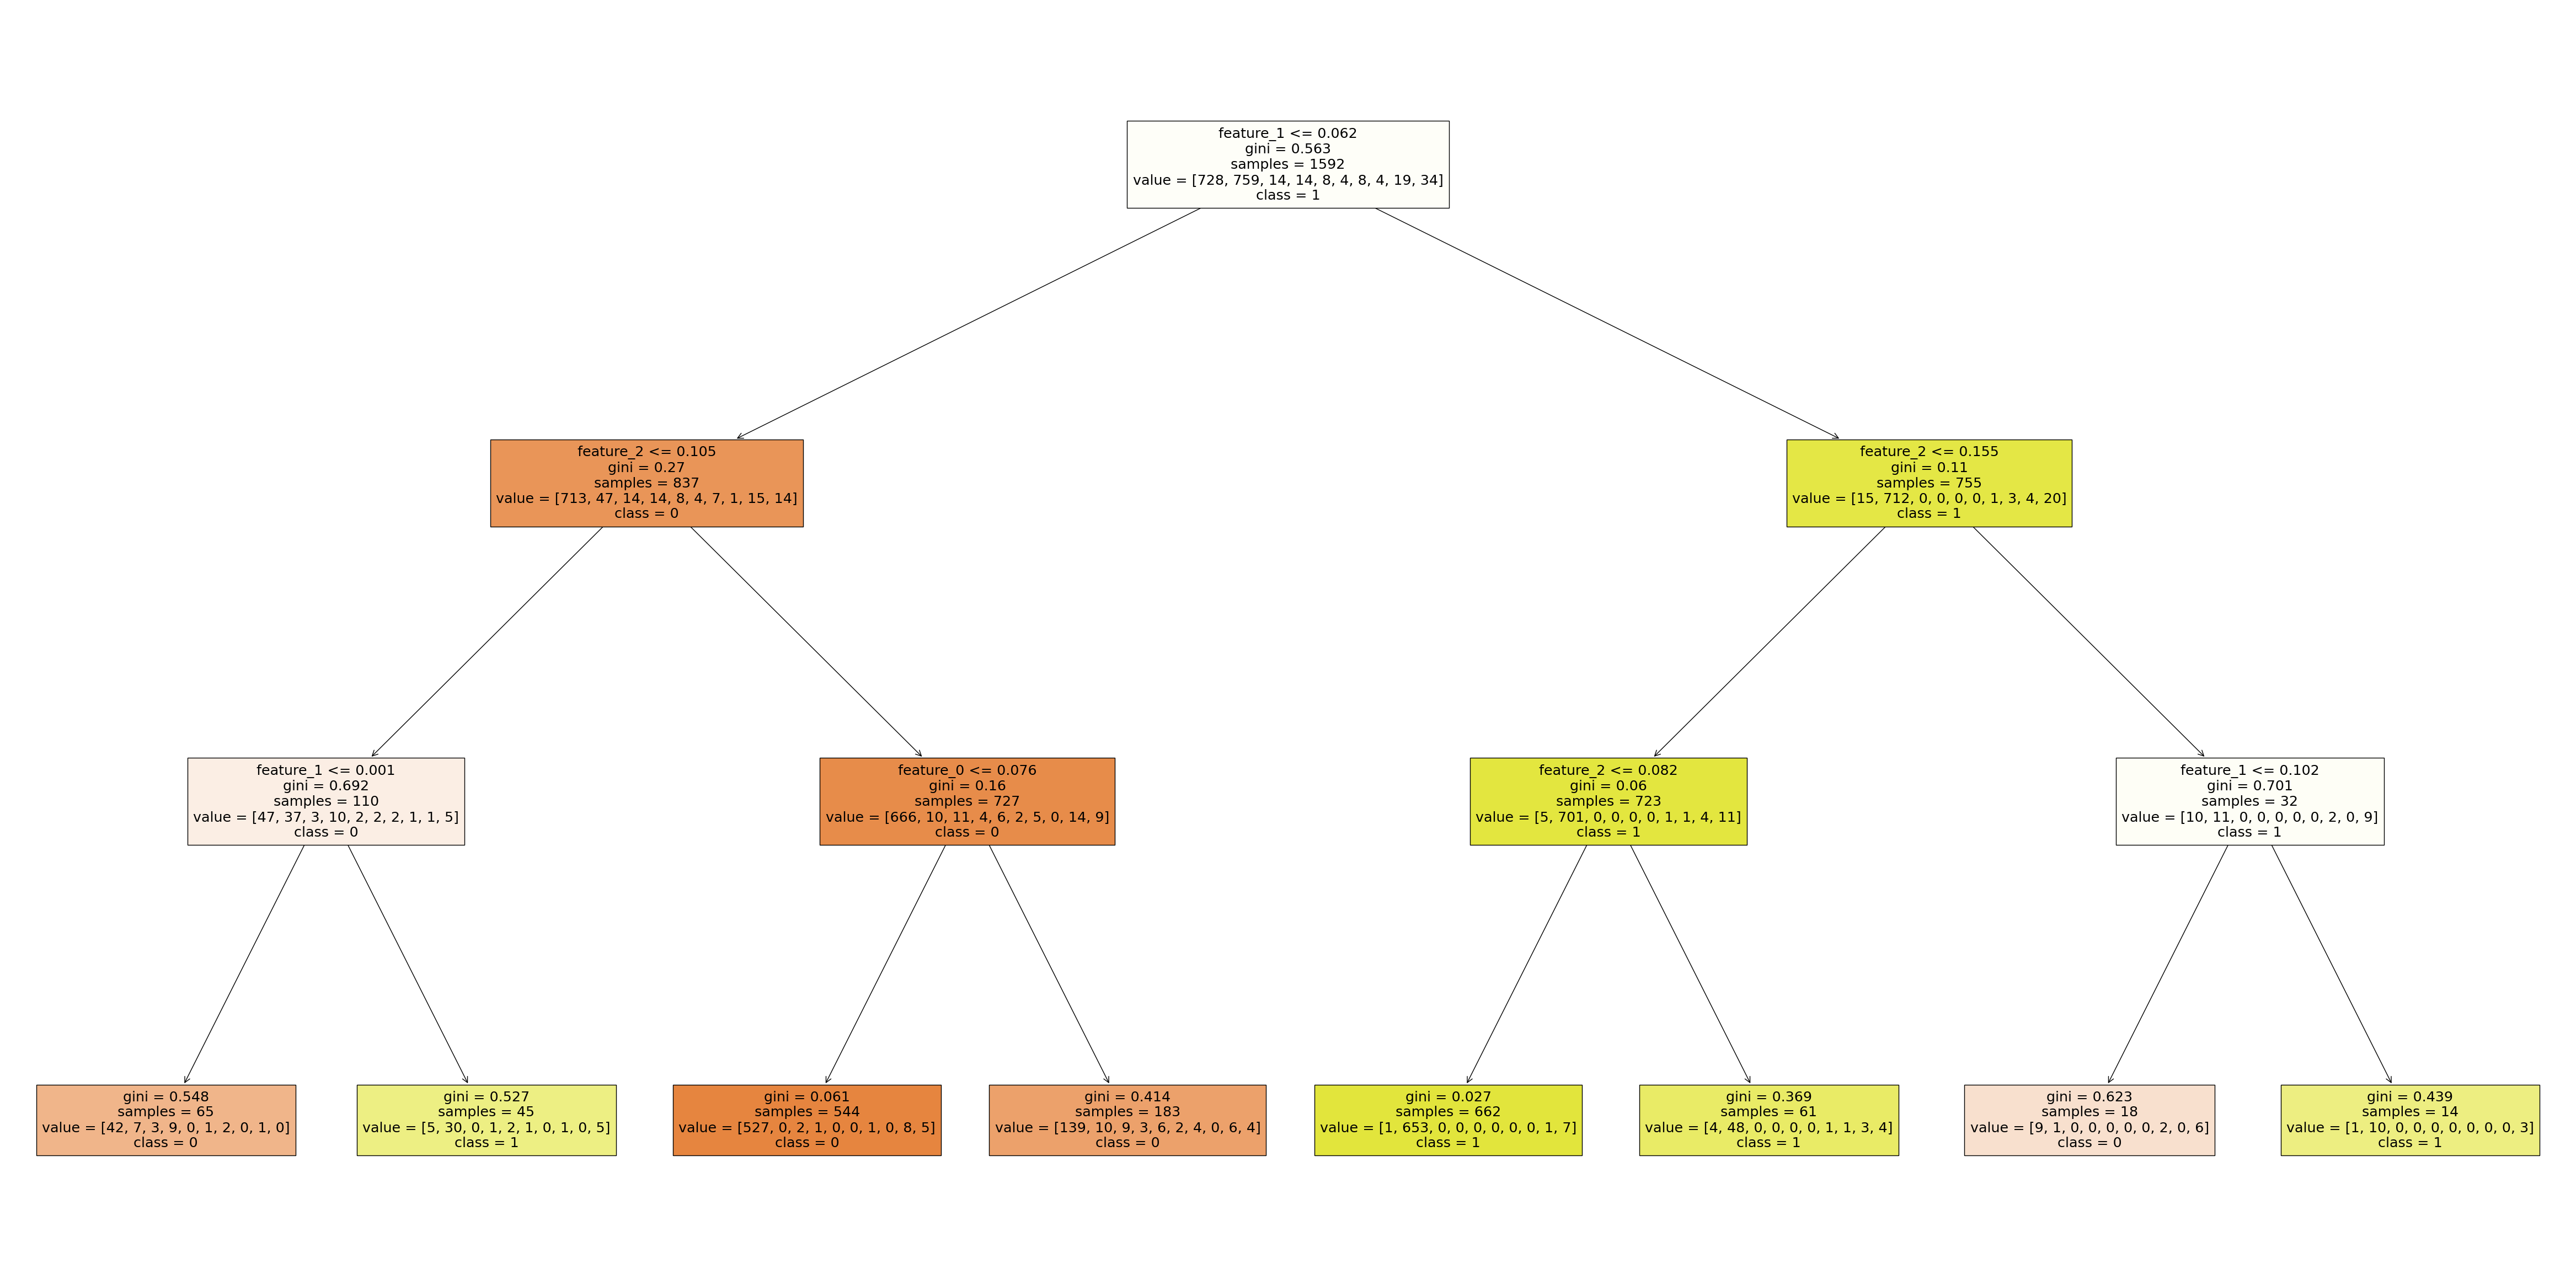

In [15]:
plt.figure(figsize=(60,30))
plot_tree(best_clf, feature_names=[f"feature_{i}" for i in range(best_n_components)], class_names=[str(i) for i in np.unique(Y)], filled=True)
plt.show()

# Extract the decision rules
# tree_rules = export_text(best_clf, feature_names=[f"feature_{i}" for i in range(X.shape[1])])
# print(tree_rules)